In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report



## Carregando os dados

In [2]:
df_treinamento = pd.read_pickle('./dataset/base_treinamento_testes.pkl')
df_validacao = pd.read_pickle('./dataset/base_submission.pkl')

In [3]:
df_treinamento.shape

(25699, 18)

In [4]:
df_treinamento.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25699 entries, 4146 to 52277
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   codigo_vaga                       25699 non-null  int64  
 1   ultimo_salario_candidato          25699 non-null  float64
 2   ultimo_cargo_candidato            25699 non-null  object 
 3   area_interesse_candidato          21879 non-null  object 
 4   nivel_candidato                   25100 non-null  object 
 5   formacao_candidato                25699 non-null  object 
 6   cidade_candidato                  25693 non-null  object 
 7   nivel_ingles_candidato            25699 non-null  float64
 8   nivel_espanhol_candidato          25699 non-null  float64
 9   mediana_teste_ingles_candidato    25699 non-null  float64
 10  mediana_teste_espanhol_candidato  25699 non-null  float64
 11  mediana_teste_logica_candidato    25699 non-null  float64
 12  median

In [5]:
df_treinamento.head(15)

,codigo_vaga,ultimo_salario_candidato,ultimo_cargo_candidato,area_interesse_candidato,nivel_candidato,formacao_candidato,cidade_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,mediana_teste_ingles_candidato,mediana_teste_espanhol_candidato,mediana_teste_logica_candidato,mediana_teste_outros_candidato,cargo_vaga,nivel_vaga,formacao_vaga,cidade_vaga,aprovado_vaga
4146,-5433147389500583028,0.0,INDUSTRIAL TRAINEE,ENGENHARIA QUIMICA,JUNIOR/TRAINEE,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SALVADOR,2.0,1.0,6.450,0.000,6.2500,7.000,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4147,-5433147389500583028,1500.0,DESENVOLVIMENTO ENGENHEIRO PRO,ADMINISTRACAO DE EMPRESAS,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,4.0,1.0,8.000,0.000,7.9900,8.200,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4148,-5433147389500583028,2050.0,CLIENTE ESTAGIO QUALIDADE,ENGENHARIA DE PRODUCAO,ESTAGIO,FORMACAO SUPERIOR COMPLETA,ARUJA,2.0,0.0,3.875,0.000,5.3300,5.400,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4149,-5433147389500583028,0.0,CONTA EXECUTIVO PARCERIA,MARKETING,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,3.0,0.0,7.250,0.000,7.9900,6.250,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4150,-5433147389500583028,1890.0,CICLO PDCA,MARKETING,AUXILIAR/OPERACIONAL,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SAO PAULO,3.0,4.0,5.250,6.375,6.6500,7.000,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4151,-5433147389500583028,3400.0,ANALISTA CUSTOMER SERVICE,ADMINISTRACAO COMERCIAL/VENDAS,JUNIOR/TRAINEE,FORMACAO SUPERIOR COMPLETA,SAO PAULO,3.0,0.0,4.500,0.000,5.0000,6.000,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4152,-5433147389500583028,1500.0,AMBIENTAL ANALISTA AUXILIAR,QUALIDADE,AUXILIAR/OPERACIONAL,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,TREMEMBE,2.0,0.0,3.000,0.000,5.9900,2.850,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4153,-5433147389500583028,1253.0,ESTAGIO,ENGENHARIA QUIMICA,ESTAGIO,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SAO BERNARDO DO CAMPO,3.0,1.0,4.625,0.000,7.8350,4.900,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4154,-5433147389500583028,4500.0,ANALISTA CORPORATIVO HUMANOS R,RECURSOS HUMANOS,PLENO,POS-GRADUACAO NO NIVEL ESPECIALIZACAO,SAO PAULO,4.0,1.0,7.625,0.000,8.0500,7.600,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0
4155,-5433147389500583028,0.0,APRENDIZ ESTAGIO,None,ESTAGIO,FORMACAO SUPERIOR COMPLETA,PARAGUACU PAULISTA,0.0,0.0,0.000,0.000,0.0000,3.100,PROGRAMA TRAINEE,JUNIOR/TRAINEE,FORMACAO SUPERIOR (CURSANDO),None,0


## Pré processamento

In [6]:
def summaryBase(df):
    result = []
    for column in df.columns:
        col_type = df[column].dtype
        value_counts = df[column].value_counts()
        num_na_null_none = df[column].isna().sum()

        new_line = ({
            'col_name': column,
            'col_type': col_type,
            'num_distinct_values': len(value_counts),
            'num_na': num_na_null_none,
            'first_5_values': value_counts.index[:5].to_list()
        })

        result.append(new_line)

    return pd.DataFrame(result)


In [7]:
summaryBase(df_treinamento)

,col_name,col_type,num_distinct_values,num_na,first_5_values
0,codigo_vaga,int64,20,0,"[-4680893303693323076, -5433147389500583028, 3..."
1,ultimo_salario_candidato,float64,1803,0,"[0.0, 2000.0, 3000.0, 1500.0, 2500.0]"
2,ultimo_cargo_candidato,object,8519,0,"[ESTAGIO, NAO CLASSIFICADO, TRAINEE, CONSULTOR..."
3,area_interesse_candidato,object,115,3820,"[ADMINISTRACAO COMERCIAL/VENDAS, ENGENHARIA DE..."
4,nivel_candidato,object,9,599,"[JUNIOR/TRAINEE, ESTAGIO, PLENO, AUXILIAR/OPER..."
5,formacao_candidato,object,9,0,"[FORMACAO SUPERIOR COMPLETA, POS-GRADUACAO NO ..."
6,cidade_candidato,object,1278,6,"[SAO PAULO, RIO DE JANEIRO, BELO HORIZONTE, CA..."
7,nivel_ingles_candidato,float64,5,0,"[4.0, 3.0, 0.0, 2.0, 1.0]"
8,nivel_espanhol_candidato,float64,5,0,"[0.0, 1.0, 2.0, 3.0, 4.0]"
9,mediana_teste_ingles_candidato,float64,1203,0,"[0.0, 7.0, 7.5, 6.0, 8.0]"


In [8]:
col_cat_na = df_treinamento.columns[df_treinamento.isna().any()].tolist()
col_cat_na

['area_interesse_candidato',
 'nivel_candidato',
 'cidade_candidato',
 'cargo_vaga',
 'cidade_vaga']

In [9]:
for col in col_cat_na:
    moda = df_treinamento[col].mode(dropna=True)
    if not moda.empty:
        df_treinamento[col].fillna(moda[0], inplace=True)
    else:
        print(f"A coluna {col} não tem moda definida para imputação.")


C:\Users\compu\AppData\Local\Temp\ipykernel_21460\2517999418.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_treinamento[col].fillna(moda[0], inplace=True)


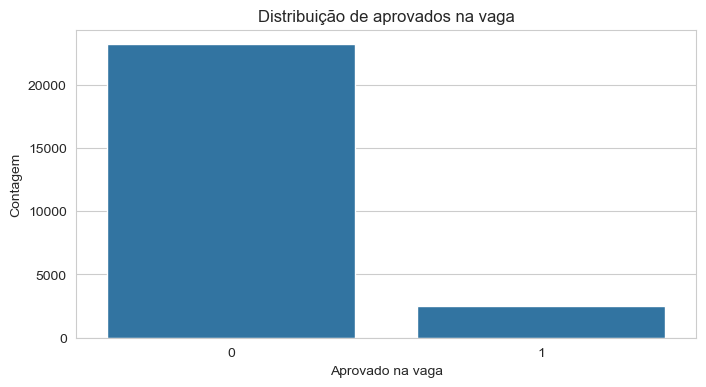

In [10]:
#Desbalanceamento de Classe Identificado
plt.figure(figsize=(8, 4))
sns.countplot(data=df_treinamento, x='aprovado_vaga')
plt.title("Distribuição de aprovados na vaga")
plt.xlabel("Aprovado na vaga")
plt.ylabel("Contagem")
plt.show()


In [11]:
df_treinamento = df_treinamento.drop(columns=['codigo_vaga'])

In [12]:
summaryBase(df_treinamento)

,col_name,col_type,num_distinct_values,num_na,first_5_values
0,ultimo_salario_candidato,float64,1803,0,"[0.0, 2000.0, 3000.0, 1500.0, 2500.0]"
1,ultimo_cargo_candidato,object,8519,0,"[ESTAGIO, NAO CLASSIFICADO, TRAINEE, CONSULTOR..."
2,area_interesse_candidato,object,115,0,"[ADMINISTRACAO COMERCIAL/VENDAS, ENGENHARIA DE..."
3,nivel_candidato,object,9,0,"[JUNIOR/TRAINEE, ESTAGIO, PLENO, AUXILIAR/OPER..."
4,formacao_candidato,object,9,0,"[FORMACAO SUPERIOR COMPLETA, POS-GRADUACAO NO ..."
5,cidade_candidato,object,1278,0,"[SAO PAULO, RIO DE JANEIRO, BELO HORIZONTE, CA..."
6,nivel_ingles_candidato,float64,5,0,"[4.0, 3.0, 0.0, 2.0, 1.0]"
7,nivel_espanhol_candidato,float64,5,0,"[0.0, 1.0, 2.0, 3.0, 4.0]"
8,mediana_teste_ingles_candidato,float64,1203,0,"[0.0, 7.0, 7.5, 6.0, 8.0]"
9,mediana_teste_espanhol_candidato,float64,118,0,"[0.0, 6.0, 4.75, 5.5, 4.0]"


In [13]:

OneHot = OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False)
LabelEnc = LabelEncoder()

ColHot = ['nivel_vaga', 'formacao_vaga']
ColLab = ['cidade_vaga', 'cargo_vaga', 'formacao_candidato', 'nivel_candidato']

# Aplicar OneHotEncoder (gera novas colunas)
for col in ColHot:
    encoded = OneHot.fit_transform(df_treinamento[[col]])  # precisa ser 2D
    cols_encoded = OneHot.get_feature_names_out([col])
    df_encoded = pd.DataFrame(encoded, columns=cols_encoded, index=df_treinamento.index)
    df_treinamento = pd.concat([df_treinamento.drop(columns=[col]), df_encoded], axis=1)

# Aplicar LabelEncoder (substitui a coluna original)
for col in ColLab:
    df_treinamento[col] = LabelEnc.fit_transform(df_treinamento[col])

In [14]:
col_hight_values = ['ultimo_cargo_candidato', 'area_interesse_candidato', 'cidade_candidato']
limiar = 11

for col in col_hight_values:
    frequencias = df_treinamento[col].value_counts()

    categorias_raras = frequencias[frequencias < limiar].index

    df_treinamento[col] = df_treinamento[col].apply(lambda x: 'raro' if x in categorias_raras else x)


In [15]:
summaryBase(df_treinamento)

,col_name,col_type,num_distinct_values,num_na,first_5_values
0,ultimo_salario_candidato,float64,1803,0,"[0.0, 2000.0, 3000.0, 1500.0, 2500.0]"
1,ultimo_cargo_candidato,object,279,0,"[raro, ESTAGIO, NAO CLASSIFICADO, TRAINEE, CON..."
2,area_interesse_candidato,object,90,0,"[ADMINISTRACAO COMERCIAL/VENDAS, ENGENHARIA DE..."
3,nivel_candidato,int32,9,0,"[4, 2, 5, 0, 7]"
4,formacao_candidato,int32,9,0,"[4, 7, 3, 8, 6]"
5,cidade_candidato,object,211,0,"[SAO PAULO, raro, RIO DE JANEIRO, BELO HORIZON..."
6,nivel_ingles_candidato,float64,5,0,"[4.0, 3.0, 0.0, 2.0, 1.0]"
7,nivel_espanhol_candidato,float64,5,0,"[0.0, 1.0, 2.0, 3.0, 4.0]"
8,mediana_teste_ingles_candidato,float64,1203,0,"[0.0, 7.0, 7.5, 6.0, 8.0]"
9,mediana_teste_espanhol_candidato,float64,118,0,"[0.0, 6.0, 4.75, 5.5, 4.0]"


In [16]:
# Aplicar LabelEncoder (substitui a coluna original)
for col in ['cidade_candidato','area_interesse_candidato','ultimo_cargo_candidato']:
    df_treinamento[col] = LabelEnc.fit_transform(df_treinamento[col])

In [17]:
summaryBase(df_treinamento)

,col_name,col_type,num_distinct_values,num_na,first_5_values
0,ultimo_salario_candidato,float64,1803,0,"[0.0, 2000.0, 3000.0, 1500.0, 2500.0]"
1,ultimo_cargo_candidato,int32,279,0,"[278, 197, 251, 275, 148]"
2,area_interesse_candidato,int32,90,0,"[0, 27, 23, 30, 32]"
3,nivel_candidato,int32,9,0,"[4, 2, 5, 0, 7]"
4,formacao_candidato,int32,9,0,"[4, 7, 3, 8, 6]"
5,cidade_candidato,int32,211,0,"[181, 210, 151, 20, 37]"
6,nivel_ingles_candidato,float64,5,0,"[4.0, 3.0, 0.0, 2.0, 1.0]"
7,nivel_espanhol_candidato,float64,5,0,"[0.0, 1.0, 2.0, 3.0, 4.0]"
8,mediana_teste_ingles_candidato,float64,1203,0,"[0.0, 7.0, 7.5, 6.0, 8.0]"
9,mediana_teste_espanhol_candidato,float64,118,0,"[0.0, 6.0, 4.75, 5.5, 4.0]"


In [18]:
df_treinamento = df_treinamento.astype(float)

## Divisão dos Dados

In [19]:
X = df_treinamento.drop('aprovado_vaga', axis=1)
y = df_treinamento['aprovado_vaga']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [21]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [22]:
selector = SelectKBest(score_func=f_classif, k=20)  # você pode ajustar o k
X_train_sel = selector.fit_transform(X_train_scaled, y_train_res)
X_test_sel = selector.transform(X_test_scaled)

C:\Users\compu\anaconda3\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=15. All the features will be returned.
  warnings.warn(


## Modelagem

In [23]:
lr_model = LogisticRegression(
    penalty='l2',
    fit_intercept=True,
    solver='liblinear',
    random_state=42,
    class_weight='balanced'
)
lr_model.fit(X_train_sel, y_train_res)
lr_pred = lr_model.predict(X_test_sel)
print("=== Logistic Regression ===")
print(f1_score(y_test, lr_pred))

=== Logistic Regression ===
0.22780832678711704
0.14009661835748793
